In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.12.0


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [11]:
train_df = pd.read_csv('./HScore/data/train.csv', index_col=0).drop(['CionScore','Coin_timestamp'],axis=1)
val_df = pd.read_csv('./HScore/data/val.csv', index_col=0).drop(['CionScore','Coin_timestamp'],axis=1)
test_df = pd.read_csv('./HScore/data/test.csv', index_col=0).drop(['CionScore','Coin_timestamp'],axis=1)

print(train_df.shape, val_df.shape, test_df.shape)

(2151, 5) (614, 5) (308, 5)


In [12]:
train_df

,Open,High,Low,Close,Volume
0,0.010909,0.009038,0.011130,0.010638,0.000274
1,0.010731,0.008742,0.010713,0.010195,0.000214
2,0.010274,0.008349,0.009911,0.009390,0.000337
3,0.009482,0.007685,0.008210,0.007804,0.000557
4,0.007877,0.006544,0.006264,0.007371,0.001044
...,...,...,...,...,...
2146,0.605723,0.589778,0.615111,0.606373,0.277508
2147,0.607224,0.611116,0.618808,0.625090,0.380599
2148,0.625683,0.609942,0.626670,0.611468,0.351140
2149,0.612158,0.594508,0.612459,0.599410,0.330366


# Chapter 13 

## 13.1 Creating windows of data
### 13.1.1 Exploring how deep learning models are trained for time series forecasting

### 13.1.2 Implementing the `DataWindow` class 

In [13]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Close', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

## 13.2 Applying baseline models
### 13.2.1 Single-step baseline model

In [18]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['Close']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['Close'])

In [19]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [21]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

baseline_last = Baseline(label_index=column_indices['Close'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [22]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

20/20 [==============================] - 0s 968us/step - loss: 0.0069 - mean_absolute_error: 0.0571


In [23]:
print(performance['Baseline - Last'][1])

0.025071438401937485


### 13.2.2 Multi-step baseline models 

In [24]:
multi_window = DataWindow(input_width=7, label_width=7, shift=1, label_columns=['Close'])

#### Predicting the last known value 

In [25]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 7, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 7, 1])

In [26]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['Close'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

19/19 [==============================] - 0s 1ms/step - loss: 1.4131 - mean_absolute_error: 0.7878


In [29]:
print(ms_val_performance['Baseline - Last'][1])
print(ms_performance['Baseline - Last'][1])

0.7878254652023315
0.37715068459510803


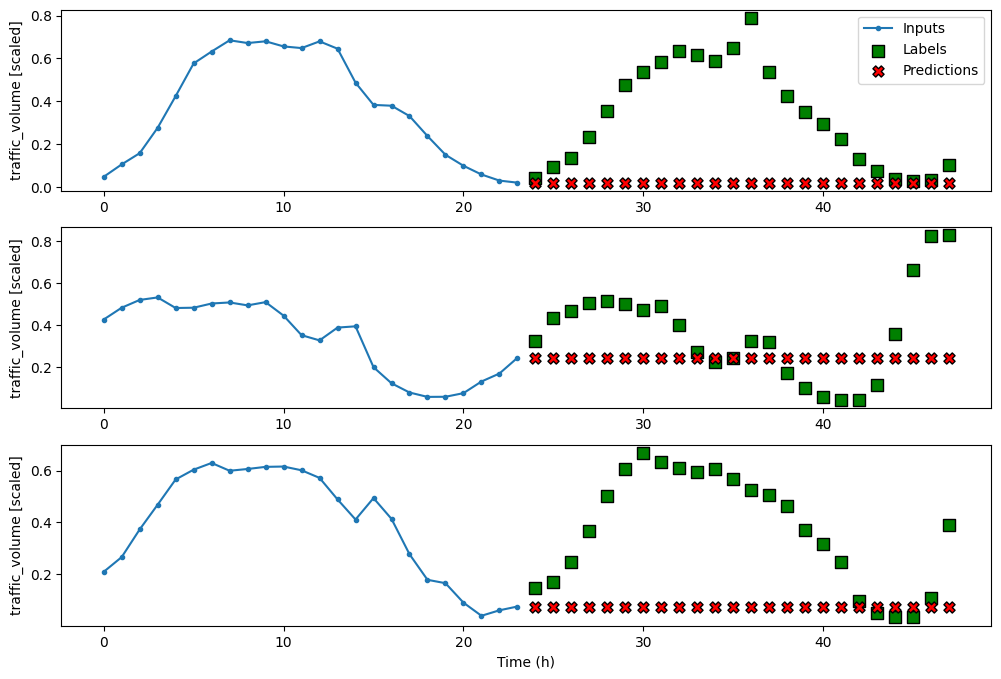

In [17]:
multi_window.plot(ms_baseline_last)

plt.savefig('figures/CH13_F10_peixeiro.png', dpi=300)

In [18]:
print(ms_performance['Baseline - Last'][1])

0.34698057174682617


#### Repeating the input sequence 

In [19]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [20]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 0s 674us/step - loss: 0.0821 - mean_absolute_error: 0.2024


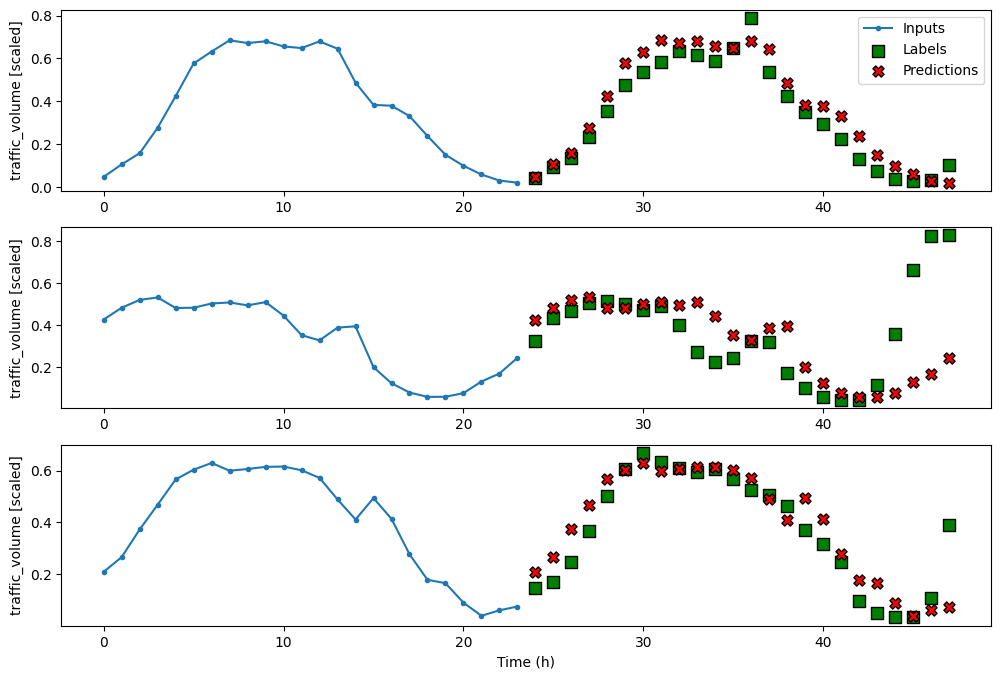

In [21]:
multi_window.plot(ms_baseline_repeat)

plt.savefig('figures/CH13_F11_peixeiro.png', dpi=300)

In [22]:
print(ms_performance['Baseline - Repeat'][1])

0.19551165401935577


### 13.2.3 Multi-output baseline model 

In [23]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

In [24]:
print(column_indices['traffic_volume'])
print(column_indices['temp'])

2
0


In [25]:
mo_baseline_last = Baseline(label_index=[0, 2])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

109/109 [==============================] - 0s 683us/step - loss: 0.0069 - mean_absolute_error: 0.0482


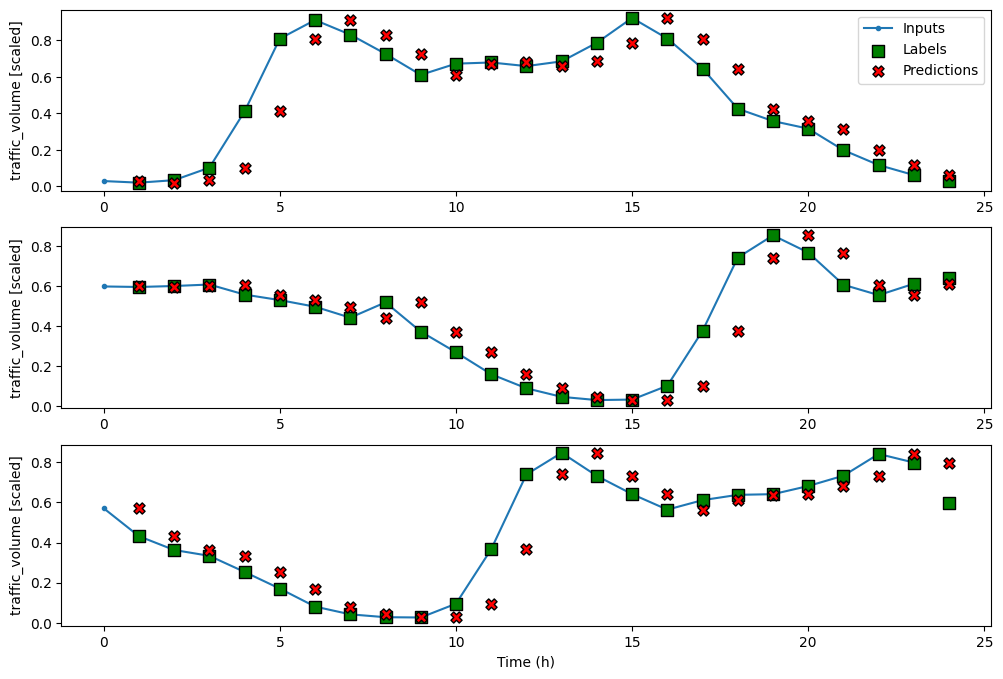

In [26]:
mo_wide_window.plot(mo_baseline_last)

plt.savefig('figures/CH13_F12_peixeiro.png', dpi=300)

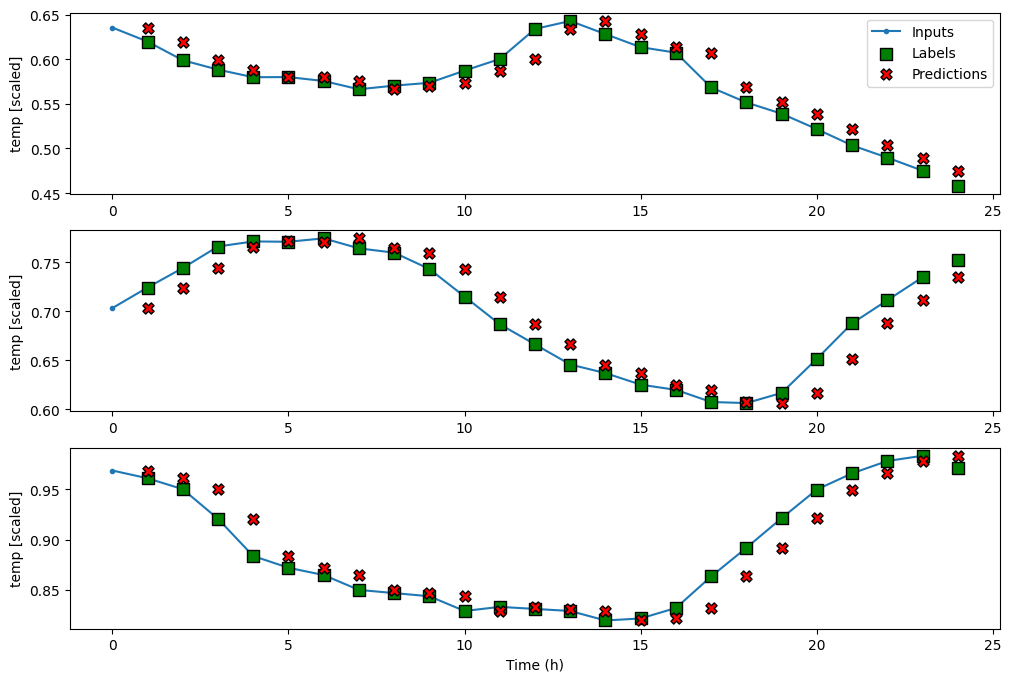

In [27]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

plt.savefig('figures/CH13_F13_peixeiro.png', dpi=300)

In [29]:
print(mo_performance['Baseline - Last'][1])

0.04710666462779045


# Chapter 14 

## 14.1 Implementing a linear model
### 14.1.1 Building a single-step linear model

In [28]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [29]:
linear = Sequential([
    Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 1s 2ms/step - loss: 0.1337 - mean_absolute_error: 0.2919 - val_loss: 0.0724 - val_mean_absolute_error: 0.2236
Epoch 2/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0422 - mean_absolute_error: 0.1641 - val_loss: 0.0253 - val_mean_absolute_error: 0.1319
Epoch 3/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0178 - mean_absolute_error: 0.1045 - val_loss: 0.0142 - val_mean_absolute_error: 0.0957
Epoch 4/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0124 - mean_absolute_error: 0.0836 - val_loss: 0.0113 - val_mean_absolute_error: 0.0817
Epoch 5/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0107 - mean_absolute_error: 0.0750 - val_loss: 0.0100 - val_mean_absolute_error: 0.0745
Epoch 6/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0098 - mean_absolute_error: 0.0705 - val_loss: 0.0094 - val_mean_absolute_error: 0.0697
Epoch 7/50
384/3

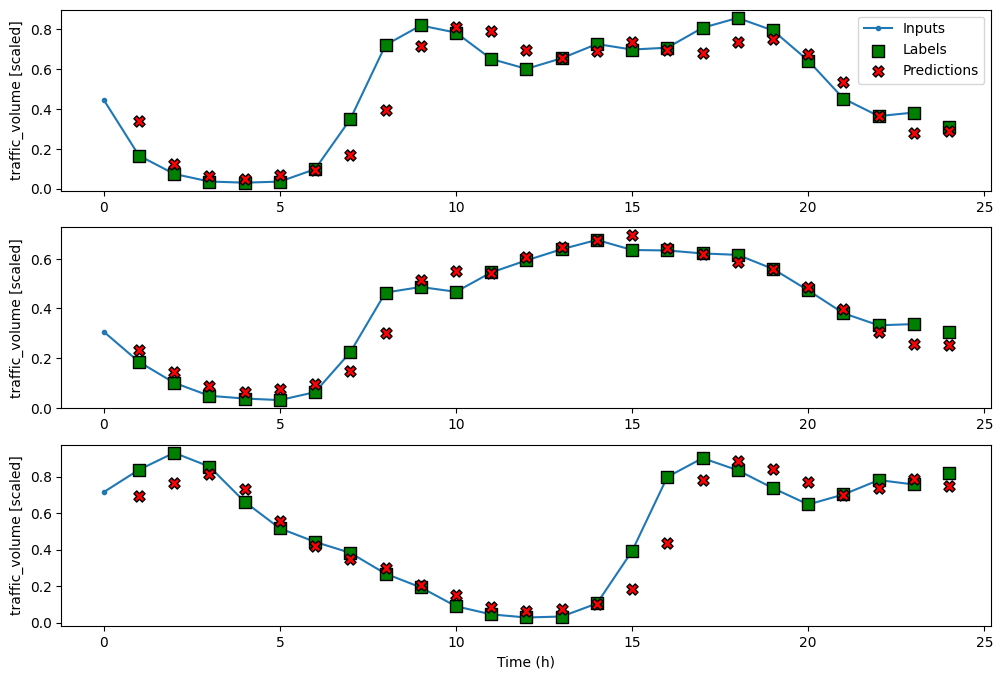

In [30]:
wide_window.plot(linear)

plt.savefig('figures/CH14_F02_peixeiro.png', dpi=300)

### 14.1.2 Building a mutli-step linear model 

In [31]:
ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0703 - mean_absolute_error: 0.2078 - val_loss: 0.0346 - val_mean_absolute_error: 0.1515
Epoch 2/50
383/383 [==============================] - 0s 1ms/step - loss: 0.0260 - mean_absolute_error: 0.1282 - val_loss: 0.0240 - val_mean_absolute_error: 0.1218
Epoch 3/50
383/383 [==============================] - 0s 1ms/step - loss: 0.0194 - mean_absolute_error: 0.1064 - val_loss: 0.0200 - val_mean_absolute_error: 0.1059
Epoch 4/50
383/383 [==============================] - 0s 1ms/step - loss: 0.0173 - mean_absolute_error: 0.0967 - val_loss: 0.0189 - val_mean_absolute_error: 0.0987
Epoch 5/50
383/383 [==============================] - 0s 1ms/step - loss: 0.0167 - mean_absolute_error: 0.0925 - val_loss: 0.0185 - val_mean_absolute_error: 0.0952
Epoch 6/50
383/383 [==============================] - 0s 1ms/step - loss: 0.0165 - mean_absolute_error: 0.0901 - val_loss: 0.0183 - val_mean_absolute_error: 0.0934
Epoch 7/50
383/3

### 14.1.3 Implementing a multi-output linear model 

In [32]:
mo_linear = Sequential([
    Dense(units=2)
])

history = compile_and_fit(mo_linear, mo_single_step_window)

mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 1s 2ms/step - loss: 0.3267 - mean_absolute_error: 0.4577 - val_loss: 0.1699 - val_mean_absolute_error: 0.3300
Epoch 2/50
384/384 [==============================] - 0s 1ms/step - loss: 0.1081 - mean_absolute_error: 0.2591 - val_loss: 0.0997 - val_mean_absolute_error: 0.2475
Epoch 3/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0726 - mean_absolute_error: 0.2071 - val_loss: 0.0695 - val_mean_absolute_error: 0.2006
Epoch 4/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0517 - mean_absolute_error: 0.1714 - val_loss: 0.0504 - val_mean_absolute_error: 0.1677
Epoch 5/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0384 - mean_absolute_error: 0.1463 - val_loss: 0.0375 - val_mean_absolute_error: 0.1437
Epoch 6/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0294 - mean_absolute_error: 0.1278 - val_loss: 0.0286 - val_mean_absolute_error: 0.1260
Epoch 7/50
384/3

## 14.2 Implementing a deep neural network
### 14.2.1 Implementing a deep neural network as a single-step model

In [33]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0079 - mean_absolute_error: 0.0623 - val_loss: 0.0042 - val_mean_absolute_error: 0.0478
Epoch 2/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_absolute_error: 0.0453 - val_loss: 0.0027 - val_mean_absolute_error: 0.0390
Epoch 3/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0032 - mean_absolute_error: 0.0411 - val_loss: 0.0022 - val_mean_absolute_error: 0.0350
Epoch 4/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0027 - mean_absolute_error: 0.0375 - val_loss: 0.0023 - val_mean_absolute_error: 0.0364
Epoch 5/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0025 - mean_absolute_error: 0.0360 - val_loss: 0.0018 - val_mean_absolute_error: 0.0315
Epoch 6/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0024 - mean_absolute_error: 0.0345 - val_loss: 0.0019 - val_mean_absolute_error: 0.0318
Epoch 7/50
384/3

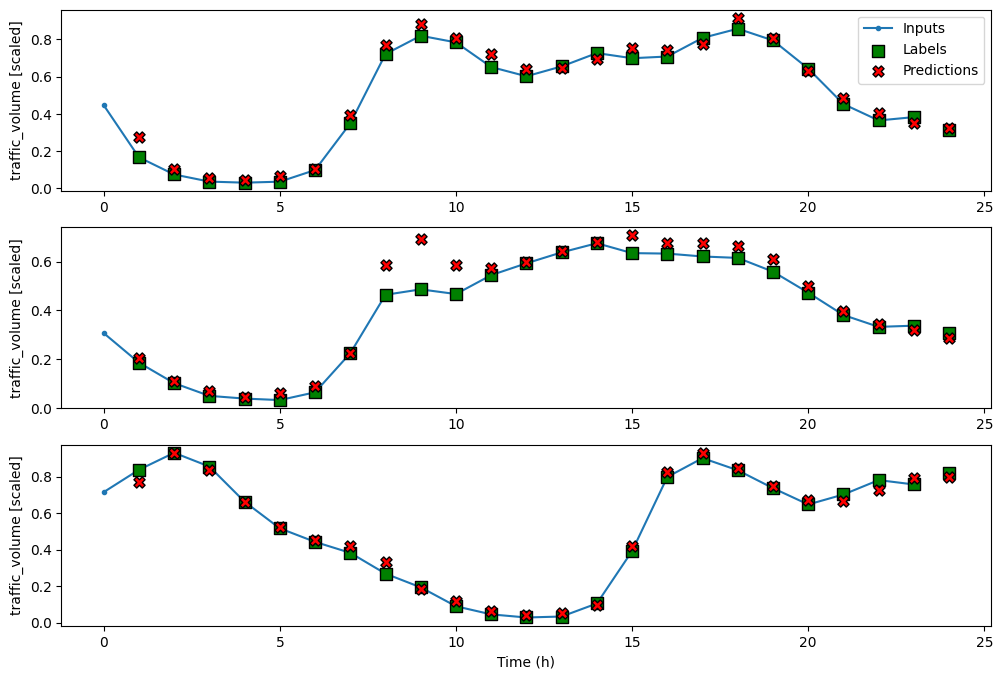

In [34]:
wide_window.plot(dense)

plt.savefig('figures/CH14_F06_peixeiro.png', dpi=300)

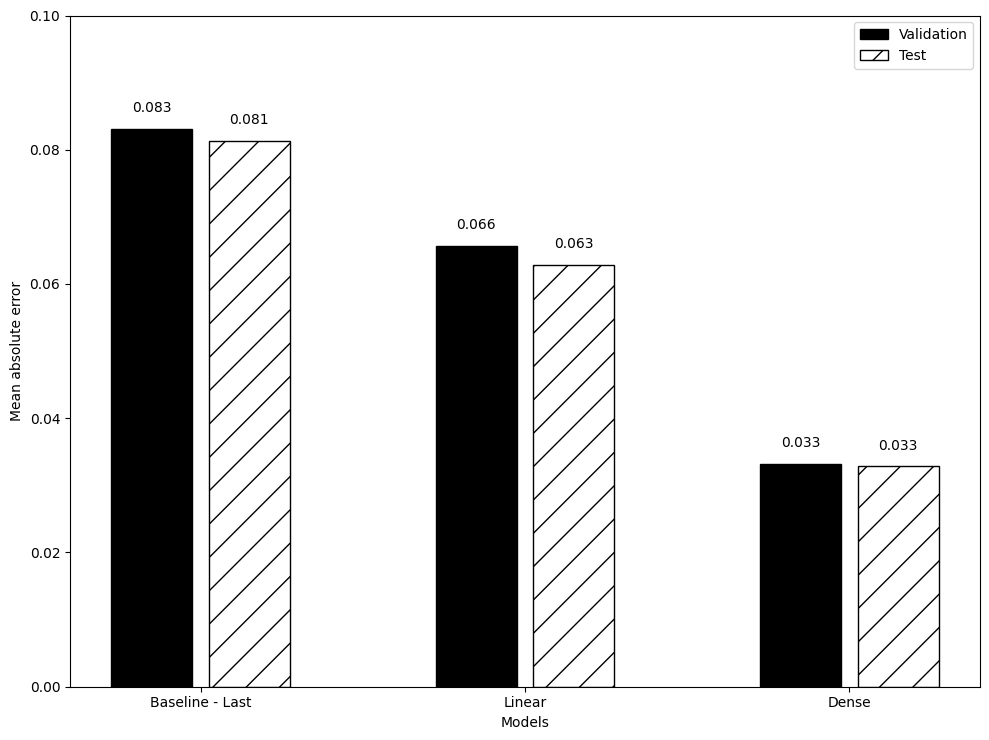

In [35]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH14_F07_peixeiro.png', dpi=300)

### 14.2.2 Implementing a deep neural network as a multi-step model 

In [36]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 2s 3ms/step - loss: 0.0268 - mean_absolute_error: 0.1065 - val_loss: 0.0157 - val_mean_absolute_error: 0.0819
Epoch 2/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0137 - mean_absolute_error: 0.0782 - val_loss: 0.0153 - val_mean_absolute_error: 0.0795
Epoch 3/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0132 - mean_absolute_error: 0.0767 - val_loss: 0.0148 - val_mean_absolute_error: 0.0845
Epoch 4/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0130 - mean_absolute_error: 0.0764 - val_loss: 0.0143 - val_mean_absolute_error: 0.0828
Epoch 5/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0127 - mean_absolute_error: 0.0755 - val_loss: 0.0145 - val_mean_absolute_error: 0.0758
Epoch 6/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0126 - mean_absolute_error: 0.0751 - val_loss: 0.0143 - val_mean_absolute_error: 0.0750
Epoch 7/50
383/3

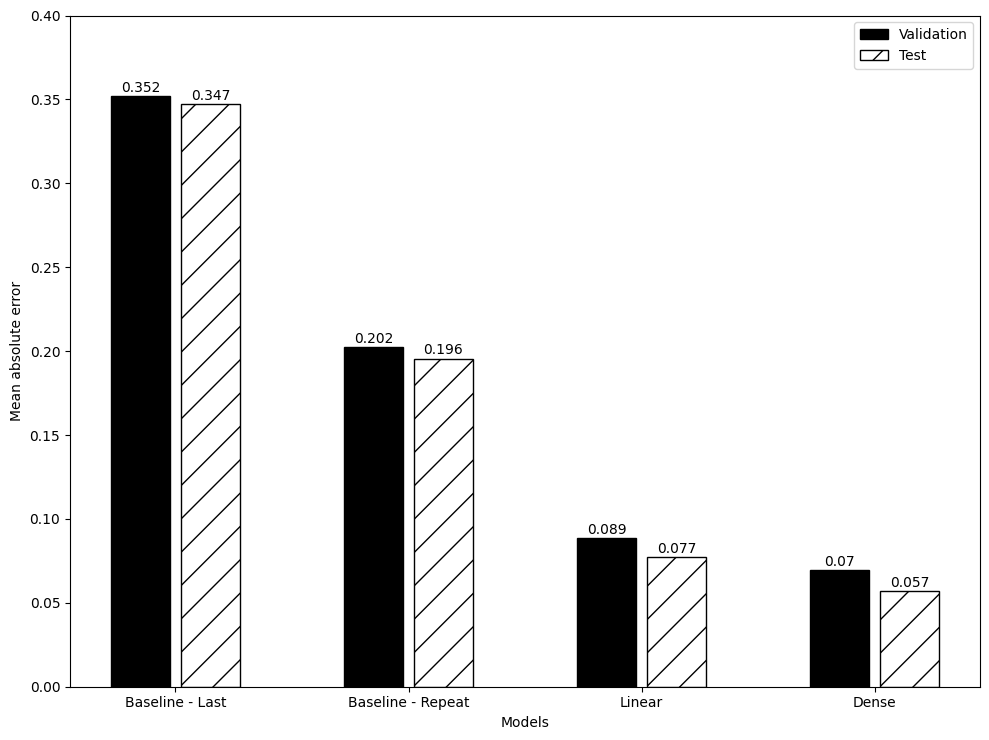

In [37]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH14_F08_peixeiro.png', dpi=300)

### 14.2.3 Implementing a deep neural network as a multi-output model 

In [38]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 2s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0550 - val_loss: 0.0030 - val_mean_absolute_error: 0.0346
Epoch 2/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0028 - mean_absolute_error: 0.0331 - val_loss: 0.0021 - val_mean_absolute_error: 0.0293
Epoch 3/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0023 - mean_absolute_error: 0.0304 - val_loss: 0.0019 - val_mean_absolute_error: 0.0294
Epoch 4/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0020 - mean_absolute_error: 0.0284 - val_loss: 0.0018 - val_mean_absolute_error: 0.0299
Epoch 5/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0019 - mean_absolute_error: 0.0273 - val_loss: 0.0014 - val_mean_absolute_error: 0.0239
Epoch 6/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0018 - mean_absolute_error: 0.0259 - val_loss: 0.0012 - val_mean_absolute_error: 0.0225
Epoch 7/50
384/3

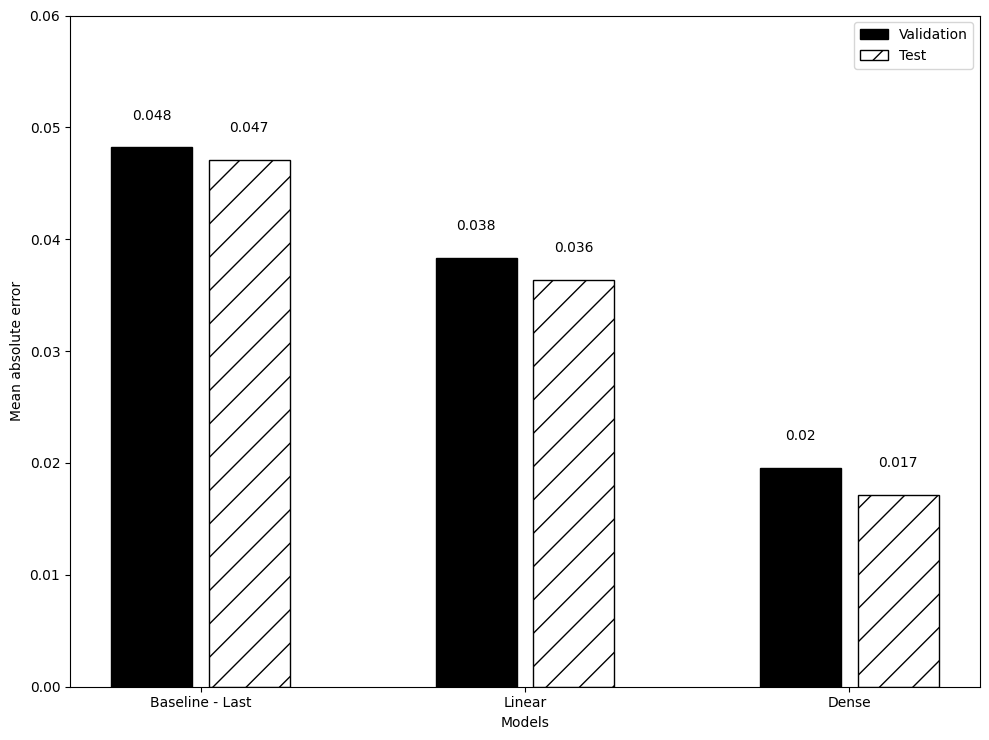

In [39]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH14_F09_peixeiro.png', dpi=300)